In [1]:
# Tahap 1: Setup

!nvidia-smi
!pip install cudf-cu12 cuml-cu12 --extra-index-url=https://pypi.nvidia.com

/bin/bash: line 1: nvidia-smi: command not found
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.3/642.3 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.7/737.7 kB 108.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 136.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 128.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.2/477.2 MB 29.8 MB/s eta 0:00:00


In [2]:
!pip install implicit==0.7.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for implicit: filename=implicit-0.7.2-cp312-cp312-linux_x86_64.whl size=938107 sha256=a8a2e36b0e62b6a9e2e9e39fd67894ca7cd71879419cbd363b4e891774856dfe
  Stored in directory: /root/.cache/pip/wheels/b2/00/4f/9ff8af07a0a53ac6007ea5d739da19cfe147a2df542b6899f8
Successfully built implicit


In [3]:
# Tahap 2: Import dan Load Dataset

import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from implicit.bpr import BayesianPersonalizedRanking
from tqdm import tqdm

df = pd.read_csv("train.csv")
print("Jumlah data awal:", len(df))

Jumlah data awal: 269764


In [4]:
# TAHAP 3 — Fltering Data (USER ≥ 5 INTERAKSI)
MIN_USER_INTERACTIONS = 5

# Hitung jumlah interaksi per user
user_interaction_counts = df["user_id"].value_counts()

# Ambil user yang memenuhi threshold
valid_users = user_interaction_counts[
    user_interaction_counts >= MIN_USER_INTERACTIONS
].index

# Filter dataframe
df = df[df["user_id"].isin(valid_users)].reset_index(drop=True)

print("Jumlah data setelah filtering user ≥ 5 interaksi:", len(df))
print("Jumlah user tersisa:", df["user_id"].nunique())
print("Jumlah item tersisa:", df["item_id"].nunique())

Jumlah data setelah filtering user ≥ 5 interaksi: 261144
Jumlah user tersisa: 11721
Jumlah item tersisa: 120497


In [5]:
# Tahap 4: Encode User dan Item ke Index Numerik

user_enc, item_enc = LabelEncoder(), LabelEncoder()

df["user_idx"] = user_enc.fit_transform(df["user_id"])
df["item_idx"] = item_enc.fit_transform(df["item_id"])

n_users = df["user_idx"].nunique()
n_items = df["item_idx"].nunique()

print(f"Jumlah user (idx): {n_users}")
print(f"Jumlah item (idx): {n_items}")

Jumlah user (idx): 11721
Jumlah item (idx): 120497


In [6]:
# Tahap 5: Bangun User dan Item Matrix
user_item_matrix = csr_matrix(
    (np.ones(len(df), dtype=np.float32),
     (df["user_idx"], df["item_idx"])),
    shape=(n_users, n_items)
)

print("user_item_matrix.shape =", user_item_matrix.shape)
print("nnz (jumlah interaksi) =", user_item_matrix.nnz)

user_item_matrix.shape = (11721, 120497)
nnz (jumlah interaksi) = 261144


**BPR (Bayesian Personalized Ranking)**

In [7]:
# Tahap 6:Training Model BPR
bpr_model = BayesianPersonalizedRanking(
    factors=128,           # lebih banyak latent factor → model lebih ekspresif
    learning_rate=0.01,    # lebih cepat belajar
    regularization=0.01,   # kurangi regularisasi supaya lebih fleksibel
    iterations=100,        # training lebih lama, lebih stabil
    random_state=42
)

print("\nMulai training BPR ...")
bpr_model.fit(user_item_matrix)
print("Training selesai.")


Mulai training BPR ...


  0%|          | 0/100 [00:00<?, ?it/s]

Training selesai.


In [8]:
# Tahap 7: Fungsi Rekomendasi
def recommend_for_user(user_idx, N=10):
    """Memberikan rekomendasi item untuk user tertentu."""
    if user_idx < 0 or user_idx >= n_users:
        raise ValueError(f"user_idx {user_idx} di luar jangkauan 0..{n_users-1}")

    user_vector = user_item_matrix.tocsr()[user_idx]

    ids, scores = bpr_model.recommend(
        userid=user_idx,
        user_items=user_vector,
        N=N,
        filter_already_liked_items=True
    )

    orig_item_ids = item_enc.inverse_transform([int(i) for i in ids])
    return pd.DataFrame({
        "item_idx": ids.astype(int),
        "item_id": orig_item_ids,
        "score": scores
    })

In [9]:
# Tahap 8: Split Data
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42
)

train_matrix = csr_matrix(
    (np.ones(len(train_df), dtype=np.float32),
     (train_df["user_idx"], train_df["item_idx"])),
    shape=(n_users, n_items)
)

test_matrix = csr_matrix(
    (np.ones(len(test_df), dtype=np.float32),
     (test_df["user_idx"], test_df["item_idx"])),
    shape=(n_users, n_items)
)

In [10]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Konversi ke matriks sparse
train_matrix = csr_matrix(
    (np.ones(len(train_df), dtype=np.float32), (train_df["user_idx"], train_df["item_idx"])),
    shape=(n_users, n_items)
)

test_matrix = csr_matrix(
    (np.ones(len(test_df), dtype=np.float32), (test_df["user_idx"], test_df["item_idx"])),
    shape=(n_users, n_items)
)

In [11]:
# Tahap 9 : EVALUASI MAP@K

def average_precision_at_k(actual, predicted, k=10):
    """Hitung average precision at k untuk satu user."""

    predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if len(actual) == 0:
        return 0.0

    return score / min(len(actual), k)


def mean_average_precision(model, train_matrix, test_matrix, k=10):
    aps = []

    for user_idx in tqdm(range(train_matrix.shape[0])):
        recommended, _ = model.recommend(
            userid=user_idx,
            user_items=train_matrix[user_idx],
            N=k,
            filter_already_liked_items=True
        )

        actual = test_matrix[user_idx].indices
        if len(actual) == 0:
            continue

        ap = average_precision_at_k(actual, recommended, k)
        aps.append(ap)

    return np.mean(aps) if aps else 0.0


map_score = mean_average_precision(bpr_model, train_matrix, test_matrix, k=10)
print(f"\nMean Average Precision @10: {map_score:.4f}")


100%|██████████| 11721/11721 [02:04<00:00, 94.36it/s]


Mean Average Precision @10: 0.0493


In [12]:
# TAHAP 10 — SIMPAN HASIL REKOMENDASI CSV
rows = []

TOP_K = 10  # jumlah rekomendasi per user

for user_idx in range(n_users):

    user_vector = train_matrix[user_idx]

    # dapatkan 10 rekomendasi
    ids, scores = bpr_model.recommend(
        userid=user_idx,
        user_items=user_vector,
        N=TOP_K,
        filter_already_liked_items=True
    )

    # convert ke original ID
    orig_user_id = user_enc.inverse_transform([user_idx])[0]
    orig_item_ids = item_enc.inverse_transform(ids.astype(int))

    # gabungkan jadi satu string
    items_joined = " ".join([str(i) for i in orig_item_ids])

    # append ke rows
    rows.append([orig_user_id, items_joined])

# Buat DataFrame
submission_df = pd.DataFrame(rows, columns=["user_id", "item_id"])

# Simpan CSV
submission_df.to_csv("bpr_recommendations.csv", index=False)

print("File rekomendasi berhasil dibuat: bpr_recommendations.csv")
submission_df.head()

File rekomendasi berhasil dibuat: bpr_recommendations.csv


,user_id,item_id
0,8,0971880107 0140124381 0449210820 340412846X 00...
1,99,0525945636 0451197399 0670031208 0060558199 03...
2,114,0312995423 0380731851 0440241537 0446604666 04...
3,160,0449210820 340412846X 3492045170 3442453305 03...
4,183,3257227809 0060586605 0743202694 2253044903 03...


**BPR (Tuning)**

In [13]:
# TAHAP 1 — TRAINING MODEL BPR Tuning
# Hyperparameter tuning hasil rekomendasi
bpr_model = BayesianPersonalizedRanking(
    factors=256,           # lebih kaya representasi (naikkan MAP)
    learning_rate=0.008,   # stabil & cepat
    regularization=0.03,   # cegah overfitting
    iterations=250,        # cukup untuk konvergensi
    random_state=42
)

print("\nMulai training BPR (tuned)...")
bpr_model.fit(user_item_matrix)
print("Training selesai.")


Mulai training BPR (tuned)...


  0%|          | 0/250 [00:00<?, ?it/s]

Training selesai.


In [14]:
# TAHAP 2 — FUNGSI REKOMENDASI


def recommend_for_user(user_idx, N=10):
    """Memberikan rekomendasi item untuk user tertentu."""
    if user_idx < 0 or user_idx >= n_users:
        raise ValueError(f"user_idx {user_idx} di luar jangkauan 0..{n_users-1}")

    user_vector = user_item_matrix.tocsr()[user_idx]

    ids, scores = bpr_model.recommend(
        userid=user_idx,
        user_items=user_vector,
        N=N,
        filter_already_liked_items=True
    )

    orig_item_ids = item_enc.inverse_transform([int(i) for i in ids])
    return pd.DataFrame({
        "item_idx": ids.astype(int),
        "item_id": orig_item_ids,
        "score": scores
    })

In [15]:
# TAHAP 3 — SPLIT DATA (TRAIN / TEST)

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_matrix = csr_matrix(
    (np.ones(len(train_df), dtype=np.float32), (train_df["user_idx"], train_df["item_idx"])),
    shape=(n_users, n_items)
)

test_matrix = csr_matrix(
    (np.ones(len(test_df), dtype=np.float32), (test_df["user_idx"], test_df["item_idx"])),
    shape=(n_users, n_items)
)

In [16]:
# TAHAP 4 — EVALUASI MAP@10
def average_precision_at_k(actual, predicted, k=10):
    """Hitung average precision at k untuk satu user."""
    predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if len(actual) == 0:
        return 0.0

    return score / min(len(actual), k)


def mean_average_precision(model, train_matrix, test_matrix, k=10):
    aps = []

    for user_idx in tqdm(range(train_matrix.shape[0])):
        recommended, _ = model.recommend(
            userid=user_idx,
            user_items=train_matrix[user_idx],
            N=k,
            filter_already_liked_items=True
        )

        actual = test_matrix[user_idx].indices
        if len(actual) == 0:
            continue

        ap = average_precision_at_k(actual, recommended, k)
        aps.append(ap)

    return np.mean(aps) if aps else 0.0


# Jalankan evaluasi akhir
map_score = mean_average_precision(bpr_model, train_matrix, test_matrix, k=10)
print(f"\nMean Average Precision @10 (TUNED): {map_score:.4f}")

100%|██████████| 11721/11721 [03:40<00:00, 53.25it/s]



Mean Average Precision @10 (TUNED): 0.1002


In [17]:
# ============================================
# TAHAP 5 — Menyimpan CSV
# ============================================

rows = []

TOP_K = 10  # jumlah rekomendasi per user

for user_idx in range(n_users):

    user_vector = train_matrix[user_idx]

    # dapatkan 10 rekomendasi
    ids, scores = bpr_model.recommend(
        userid=user_idx,
        user_items=user_vector,
        N=TOP_K,
        filter_already_liked_items=True
    )

    # convert ke original ID
    orig_user_id = user_enc.inverse_transform([user_idx])[0]
    orig_item_ids = item_enc.inverse_transform(ids.astype(int))

    # gabungkan jadi satu string
    items_joined = " ".join([str(i) for i in orig_item_ids])

    # append ke rows
    rows.append([orig_user_id, items_joined])

# Buat DataFrame
submission_df = pd.DataFrame(rows, columns=["user_id", "item_id"])

# Simpan CSV
submission_df.to_csv("bprtuning_recommendations.csv", index=False)

print("File rekomendasi berhasil dibuat: bprtuning_recommendations.csv")
submission_df.head()

File rekomendasi berhasil dibuat: bprtuning_recommendations.csv


,user_id,item_id
0,8,8845205118 0887307876 0753804700 0971880107 04...
1,99,0743469801 0312252617 0385504209 0385334729 04...
2,114,0553582526 044661162X 0515121495 0440236673 04...
3,160,8845205118 0140308946 8408022938 3442437407 88...
4,183,3404148665 3257229364 2253044903 3492045170 34...


In [19]:
# TUNING LEARNING RATE PADA MODEL BPR
learning_rates = [0.008, 0.010, 0.015, 0.020, 0.025, 0.030, 0.035, 0.04]

results = []

for lr in learning_rates:

    print(f"\n===== Training BPR dengan learning_rate = {lr} =====")

    bpr_model = BayesianPersonalizedRanking(
        factors=256,          # TETAP
        learning_rate=lr,     # DIUBAH
        regularization=0.03,  # TETAP
        iterations=250,       # TETAP
        random_state=42
    )

    bpr_model.fit(user_item_matrix)

    map_score = mean_average_precision(
        bpr_model, train_matrix, test_matrix, k=10
    )

    print(f"MAP@10 (lr={lr}): {map_score:.4f}")

    results.append((lr, map_score))



===== Training BPR dengan learning_rate = 0.008 =====


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 11721/11721 [03:33<00:00, 54.96it/s]


MAP@10 (lr=0.008): 0.1001

===== Training BPR dengan learning_rate = 0.01 =====


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 11721/11721 [03:25<00:00, 56.98it/s]


MAP@10 (lr=0.01): 0.1561

===== Training BPR dengan learning_rate = 0.015 =====


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 11721/11721 [03:28<00:00, 56.35it/s]


MAP@10 (lr=0.015): 0.3712

===== Training BPR dengan learning_rate = 0.02 =====


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 11721/11721 [03:20<00:00, 58.38it/s]


MAP@10 (lr=0.02): 0.5806

===== Training BPR dengan learning_rate = 0.025 =====


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 11721/11721 [03:22<00:00, 58.01it/s]


MAP@10 (lr=0.025): 0.6941

===== Training BPR dengan learning_rate = 0.03 =====


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 11721/11721 [03:20<00:00, 58.59it/s]


MAP@10 (lr=0.03): 0.7667

===== Training BPR dengan learning_rate = 0.035 =====


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 11721/11721 [03:23<00:00, 57.63it/s]


MAP@10 (lr=0.035): 0.8097

===== Training BPR dengan learning_rate = 0.04 =====


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 11721/11721 [03:22<00:00, 57.88it/s]

MAP@10 (lr=0.04): 0.8339


In [20]:
# REKAPITULASI HASIL TUNING LEARNING RATE
results_df = pd.DataFrame(results, columns=["learning_rate", "MAP@10"])
results_df

,learning_rate,MAP@10
0,0.008,0.100137
1,0.010,0.156054
2,0.015,0.371242
3,0.020,0.580592
4,0.025,0.694121
5,0.030,0.766707
6,0.035,0.809668
7,0.040,0.833950


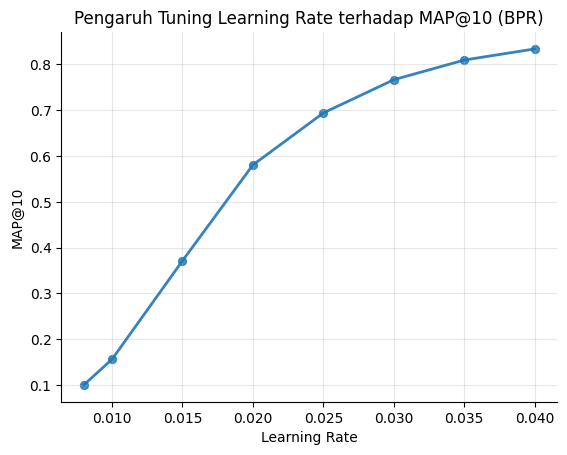

In [21]:
# Grafik Tuning Learning Rate pada Model BPR

from matplotlib import pyplot as plt

# Scatter (titik)
plt.scatter(
    results_df["learning_rate"],
    results_df["MAP@10"],
    s=32,
    alpha=0.8
)

# Line (garis tren antar titik)
plt.plot(
    results_df["learning_rate"],
    results_df["MAP@10"],
    linewidth=2,
    alpha=0.9
)

# Rapikan tampilan
plt.xlabel("Learning Rate")
plt.ylabel("MAP@10")
plt.title("Pengaruh Tuning Learning Rate terhadap MAP@10 (BPR)")
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(alpha=0.3)

plt.show()